In [7]:
#  STEP 1: Install dependencies
! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip NDVI files from Google Drive
import shutil

zip_path = "/content/drive/MyDrive/ndvi_july_dec_2022.zip"
extract_to = "/content/ndvi_july_dec_2022"

# Copy zip to /content before unzipping
shutil.copy(zip_path, "/content/ndvi_july_dec_2022.zip")
!unzip -q /content/ndvi_july_dec_2022.zip -d /content/ndvi_july_dec_2022
!ls -R /content/ndvi_july_dec_2022

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# folder = "/content/ndvi_tiffs"
folder = "/content/ndvi_july_dec_2022/ndvi_tiffs"
# folder = "/kaggle/input/ndvi-jan-june-2022/ndvi_tiffs/"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndvi_stack = []

print("Reading NDVI images...")
# for f in tqdm(files):
#     with rasterio.open(os.path.join(folder, f)) as src:
#         ndvi_read = src.read(1)  # Reads the first band (common for NDVI)
#         profile = src.profile
#         print(ndvi_read, "\n\n\n\n\n")
#         ndvi_stack.append(ndvi_read)

# # print(ndvi_stack)
# ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
# time, height, width = ndvi_stack.shape

# print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

# for f in files:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         ref_mask = np.isnan(data)
#         break

# for f in files[1:]:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         current_mask = np.isnan(data)
#         if not np.array_equal(ref_mask, current_mask):
#             print(f"Inconsistent NaN positions in file: {f}")
#             consistent = False
#             break


for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndvi_stack.append(data)

print(type(ndvi_stack[0]))
ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
time, height, width = ndvi_stack.shape

print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

print("NDVI shape:", ndvi_stack.shape)
print("NDVI stats:", np.nanmin(ndvi_stack), np.nanmax(ndvi_stack))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ndvi_july_dec_2022:
ndvi_july_dec_2022  ndvi_tiffs

/content/ndvi_july_dec_2022/ndvi_july_dec_2022:
NDVI_2022_07_july_Krishna.tif  NDVI_2022_10_octKrishna.tif
NDVI_2022_08_aug_Krishna.tif   NDVI_2022_11_nov_Krishna.tif
NDVI_2022_09_sep_Krishna.tif   NDVI_2022_12_decKrishna.tif

/content/ndvi_july_dec_2022/ndvi_tiffs:
NDVI_August_2022_Krishna.tif	NDVI_November_2022_Krishna.tif
NDVI_December_2022_Krishna.tif	NDVI_October_2022_Krishna.tif
NDVI_July_2022_Krishna.tif	NDVI_September_2022_Krishna.tif
['NDVI_August_2022_Krishna.tif', 'NDVI_December_2022_Krishna.tif', 'NDVI_July_2022_Krishna.tif', 'NDVI_November_2022_Krishna.tif', 'NDVI_October_2022_Krishna.tif', 'NDVI_September_2022_Krishna.tif']
Reading NDVI images...
<class 'numpy.ndarray'>
Loaded NDVI stack with shape: (6, 5308, 5811)
NDVI shape: (6, 5308, 5811)
NDVI stats: -0.9997653 0.9999947


In [8]:
ndvi_stack

for i, layer in enumerate(ndvi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndvi_stack).sum()
print("Total NaN values in NDVI stack:", total_nans)

total_pixels = np.prod(ndvi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")


Time step 0: 21024185 NaN values
Time step 1: 21089309 NaN values
Time step 2: 21038706 NaN values
Time step 3: 21048426 NaN values
Time step 4: 21284235 NaN values
Time step 5: 21028355 NaN values
Total NaN values in NDVI stack: 126513216
Percentage of NaN values: 68.36%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


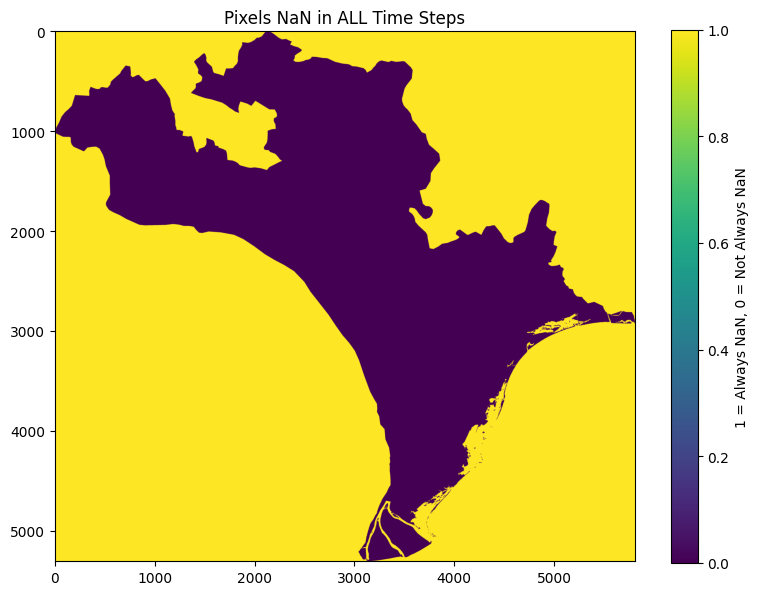

In [9]:
nan_masks = np.isnan(ndvi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [10]:
ndvi_scaled = np.empty_like(ndvi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndvi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndvi_scaled[:, i, j] = np.nan
        else:
            ndvi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val

Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [06:33<00:00, 13.49it/s]


In [11]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndvi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndvi_scaled[:, i, j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [02:12<00:00, 40.16it/s]


Training data prepared: X shape: (9462971, 5, 1), y shape: (9462971,)


In [12]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # NDVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "/content/drive/MyDrive/ndvi_lstm_model_jan_2023.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 304s 81ms/step - loss: 11486.7246 - val_loss: 0.4544
Epoch 2/5
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 321s 81ms/step - loss: 0.1090 - val_loss: 0.2056
Epoch 3/5
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 308s 77ms/step - loss: 0.0999 - val_loss: 0.2023
Epoch 4/5
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 325s 78ms/step - loss: 0.1049 - val_loss: 0.3529
Epoch 5/5
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 301s 81ms/step - loss: 0.1168 - val_loss: 0.3911


In [13]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting NDVI for the 7th month...")
X_test=[]
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        if normalized:
            series=ndvi_scaled[:,i,j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use all 6 months to predict the 7th month

        X_test.append(series[1:])
        coords_test.append([i,j])

        # # Inverse transform the prediction to original scale
        # if scalers[i, j] is not None:
        #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting NDVI for the 7th month...


100%|██████████| 5308/5308 [02:08<00:00, 41.33it/s]


In [14]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4621/4621 ━━━━━━━━━━━━━━━━━━━━ 148s 32ms/step
converting back to 2d grid
(9462971, 1)


0it [00:00, ?it/s]<ipython-input-14-2dbf15bb067a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9462971it [01:42, 91924.05it/s] 


Saving prediction to GeoTIFF...
Prediction saved as: predicted_ndvi_jan_2023.tif


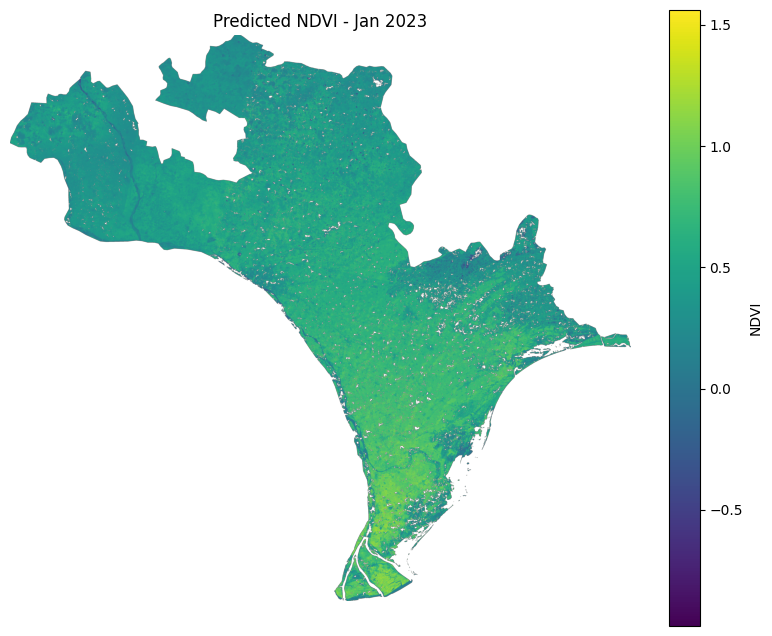

In [15]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("/content/drive/MyDrive/predicted_ndvi_jan_2023.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("Prediction saved as: predicted_ndvi_jan_2023.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title("Predicted NDVI - Jan 2023")
plt.axis('off')
plt.savefig("/content/drive/MyDrive/predicted_ndvi_jan_2023.png", dpi=300)
plt.show()